## importing libraries

In [146]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model

In [7]:
import tensorflow as tf
print(tf.__version__)

2.16.2


In [8]:
!python --version

Python 3.12.7


In [9]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot Accuracy
    axs[0].plot(model_history.history['accuracy'])
    axs[0].plot(model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1))
    axs[0].legend(['Train', 'Validation'], loc='best')

    # Plot Loss
    axs[1].plot(model_history.history['loss'])
    axs[1].plot(model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1))
    axs[1].legend(['Train', 'Validation'], loc='best')

    plt.show()


## making dictionary of images and labels

In [11]:
import os
from glob import glob

# Path to the extracted HAM10000 dataset inside the 'archive' folder
base_skin_dir = os.path.join('archive')

# Dictionary mapping image IDs (without extension) to full image paths
imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob(os.path.join(base_skin_dir, '**', '*.jpg'), recursive=True)
}

# Print to confirm it's working
print("Sample image path mapping:", list(imageid_path_dict.items())[:1])

# Dictionary for human-readable labels
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

Sample image path mapping: [('ISIC_0026784', 'archive/HAM10000_images_part_1/ISIC_0026784.jpg')]


## reading and processing data

In [13]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Assuming imageid_path_dict and lesion_type_dict are predefined
# Creating New Columns for better readability
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [14]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,archive/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,archive/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,archive/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,archive/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,archive/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


## data cleaning

In [16]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

As it is evident from the above that only age has null values which is 57 so we will fill the null values by their mean.

In [18]:
skin_df['age'] = skin_df['age'].fillna(skin_df['age'].mean())

In [19]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [20]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


## EDA

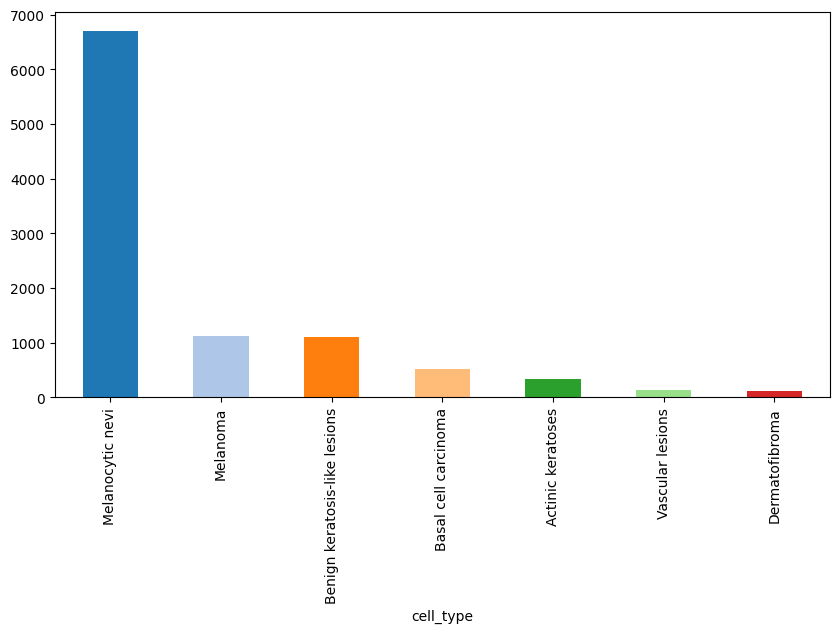

In [22]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

# Get the counts for each cell_type and plot with a color map
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1, color=plt.cm.tab20.colors)

plt.show()

Its seems from the above plot that in this dataset cell type Melanecytic nevi has very large number of instances in comparison to other cell types

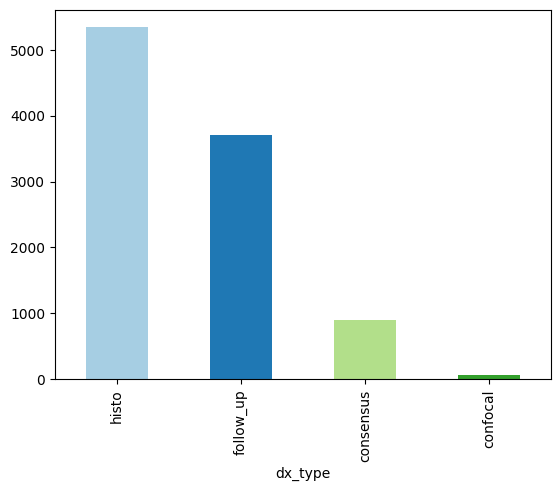

In [24]:
# Plot with different colors for each bar
skin_df['dx_type'].value_counts().plot(kind='bar', color=plt.cm.Paired.colors)

# Show the plot
plt.show()


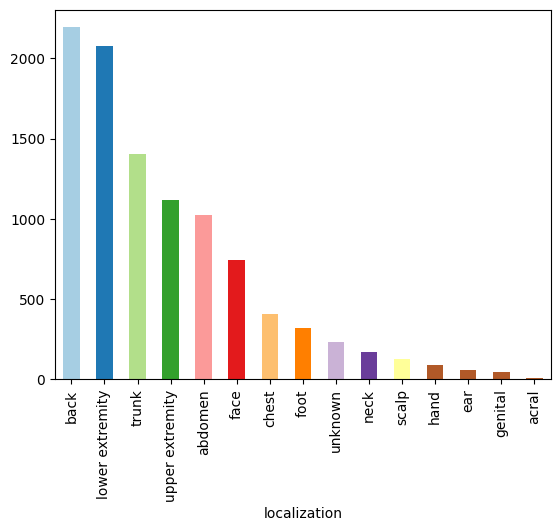

In [25]:
# Get a list of colors from the colormap
colors = plt.cm.Paired(range(len(skin_df['localization'].unique())))

# Plot with multicolors for each bar
skin_df['localization'].value_counts().plot(kind='bar', color=colors)

# Show the plot
plt.show()


It seems back , lower extremity,trunk and upper extremity are heavily compromised regions of skin cancer

<Axes: >

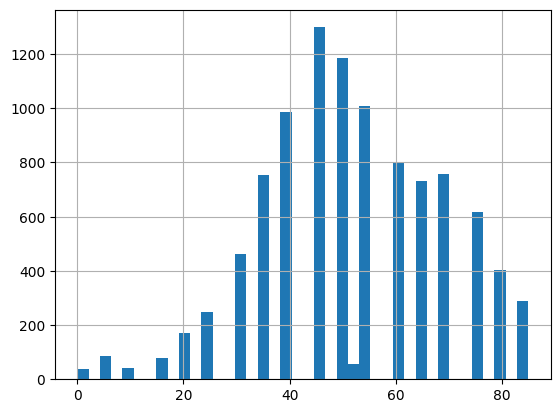

In [27]:
skin_df['age'].hist(bins=40)

It seems that there are larger instances of patients having age from 30 to 60

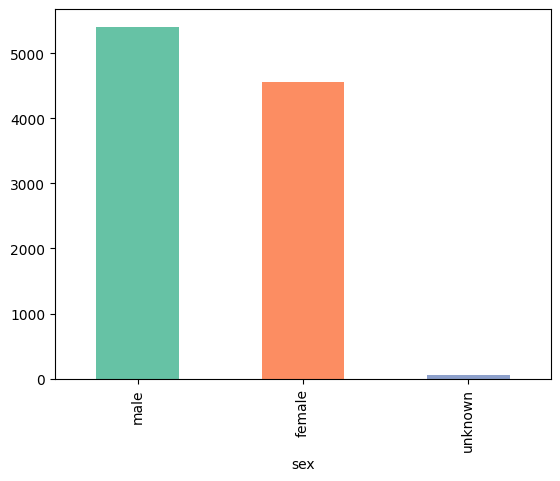

In [29]:
# Get a list of colors from a colormap (e.g., 'Set2')
colors = plt.cm.Set2(range(len(skin_df['sex'].unique())))

# Plot with multicolors for each bar
skin_df['sex'].value_counts().plot(kind='bar', color=colors)

# Show the plot
plt.show()

<Axes: xlabel='age', ylabel='cell_type_idx'>

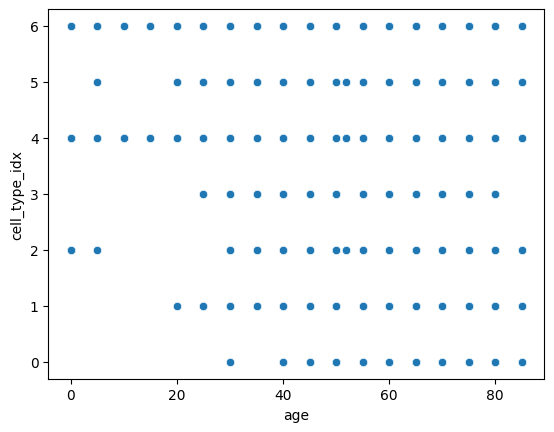

In [30]:
sns.scatterplot(x='age', y='cell_type_idx', data=skin_df)

It seems that skin cancer types 0,1, 3 and 5 which are Melanocytic nevi,dermatofibroma,Basal cell carcinoma and Vascular lesions are not much prevalant below the age of 20 years 

## loading and resizing of images

In [52]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [54]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,archive/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,archive/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,archive/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,archive/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,archive/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


In this step images will be loaded into the column named image from the image path from the image folder. We also resize the images as the original dimension of images are 450 x 600 x3 which TensorFlow can't handle, so that's why we resize it into 100 x 75.

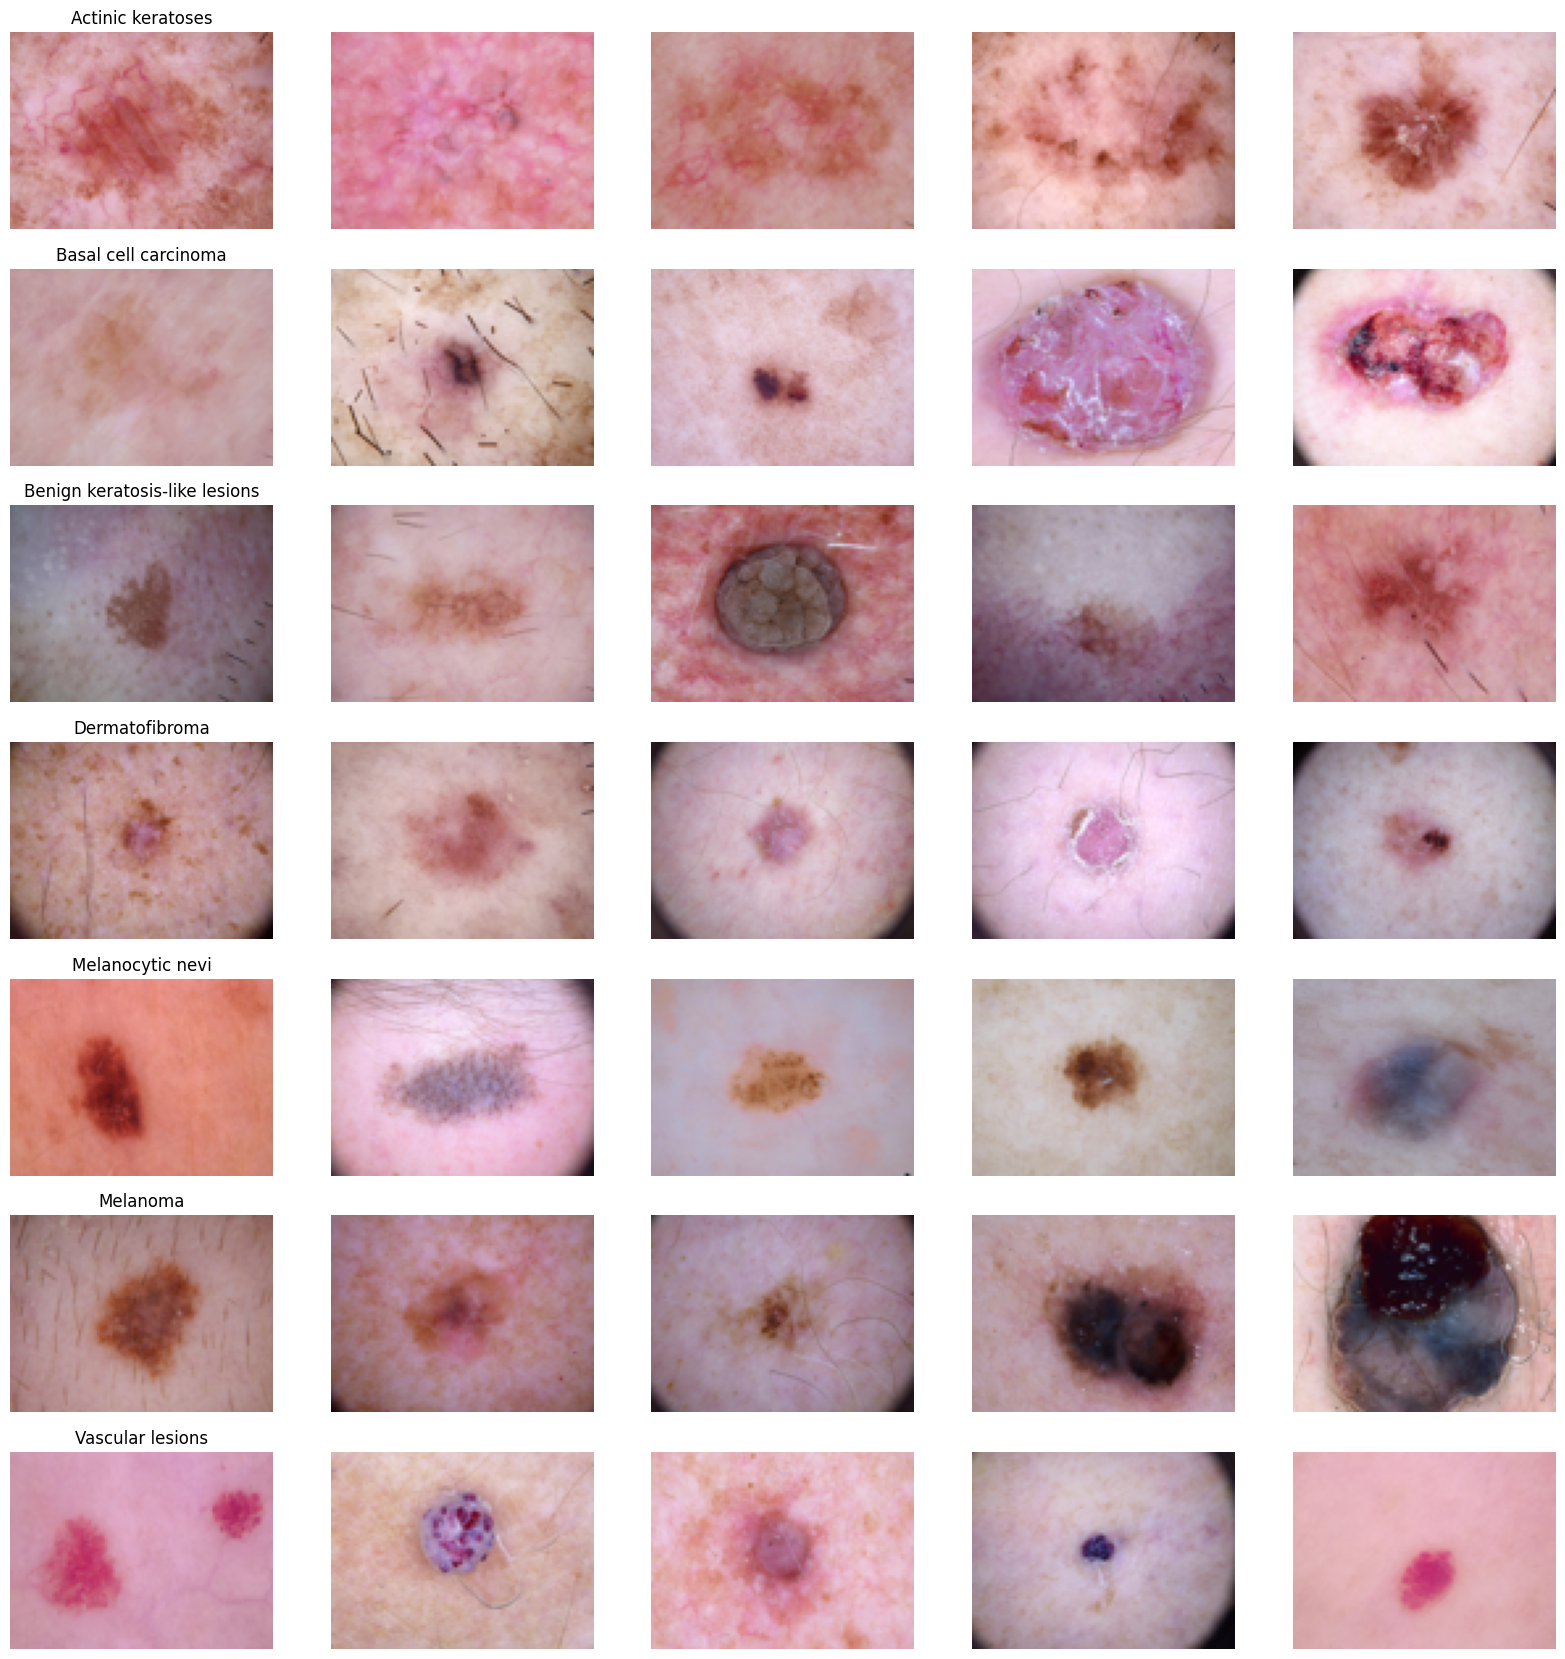

In [57]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [59]:
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    10015
Name: count, dtype: int64

In [61]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

## train test split

we split it into 80:20 ratio

In [65]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

## normalization

In [68]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

## label encoding

In [73]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

## splitting training and validation split

I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

In [77]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [79]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

## building the model

In [96]:
# Define input shape and number of output classes
input_shape = (75, 100, 3)
num_classes = 7

# Define the model
model = Sequential([
    # Explicit Input layer to prevent warning
    Input(shape=input_shape),
    
    # First Conv Block
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Second Conv Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.40),

    # Fully Connected Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Display the model summary
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 75, 100, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 75, 100, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 37, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 37, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 37, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 37, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 18, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 18, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,752,999 (14.32 MB)

 Trainable params: 3,752,999 (14.32 MB)

 Non-trainable params: 0 (0.00 B)

## setting optimizer and annealer

In [105]:
# Define the optimizer using updated argument names
optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,  # Default value in TF 2.x
    amsgrad=False
)

In [107]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [109]:
# Set a learning rate reduction callback
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',    # <-- 'val_acc' is deprecated
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=1e-5
)

## data augmentation

In [112]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image data augmentation to prevent overfitting
datagen = ImageDataGenerator(
    rotation_range=10,          # Randomly rotate images by 0–10 degrees
    zoom_range=0.1,             # Random zoom
    width_shift_range=0.1,      # Horizontal shift
    height_shift_range=0.1,     # Vertical shift
    horizontal_flip=False,      # No horizontal flip
    vertical_flip=False         # No vertical flip
)

# Fit the generator to the training data
datagen.fit(x_train)


## fitting the model

In [126]:
# Fit the model (100 epochs, Apple Silicon / macOS version)
epochs = 50
batch_size = 10

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_validate, y_validate),
    verbose=1,
    steps_per_epoch=x_train.shape[0] // batch_size,
    callbacks=[learning_rate_reduction]
)


Epoch 1/50
  3/721 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.7944 - loss: 0.8309

/opt/anaconda3/envs/tf_macos/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


721/721 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.7393 - loss: 0.7486 - val_accuracy: 0.7369 - val_loss: 0.7673 - learning_rate: 2.5000e-04
Epoch 2/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.7263 - loss: 0.7911 - val_accuracy: 0.7207 - val_loss: 0.7298 - learning_rate: 2.5000e-04
Epoch 3/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.7351 - loss: 0.7680 - val_accuracy: 0.7419 - val_loss: 0.6822 - learning_rate: 2.5000e-04
Epoch 4/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.7357 - loss: 0.7703 - val_accuracy: 0.7431 - val_loss: 0.7039 - learning_rate: 2.5000e-04
Epoch 5/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.7294 - loss: 0.7784 - val_accuracy: 0.7456 - val_loss: 0.7017 - learning_rate: 2.5000e-04
Epoch 6/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.7178 - loss: 0.7965 - val_accuracy: 0.7382 - val_loss: 0.7268 - learning_rate: 2.5000e-04
Epoch 7/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accurac

## model evaluation and saving

In [142]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)

# Print results
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

# Save the entire model to the native Keras format
model.save('model.keras')  # Save the model in Keras format (.keras)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7640 - loss: 0.6570
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7643 - loss: 0.6438
Validation: accuracy = 0.733167  ;  loss_v = 0.676482
Test: accuracy = 0.750874  ;  loss = 0.684211


In [133]:
import tensorflow as tf
print(tf.__version__)

2.16.2


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


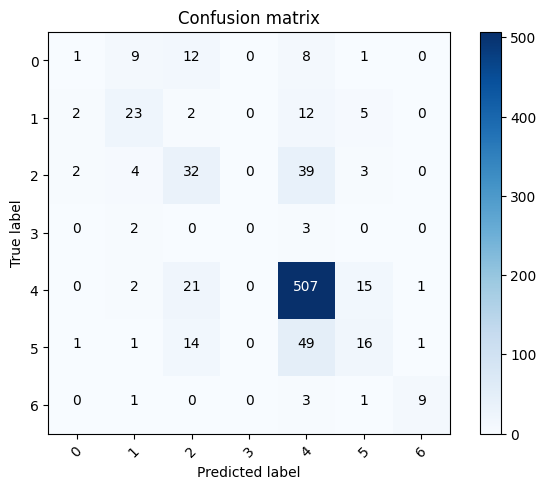

In [137]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

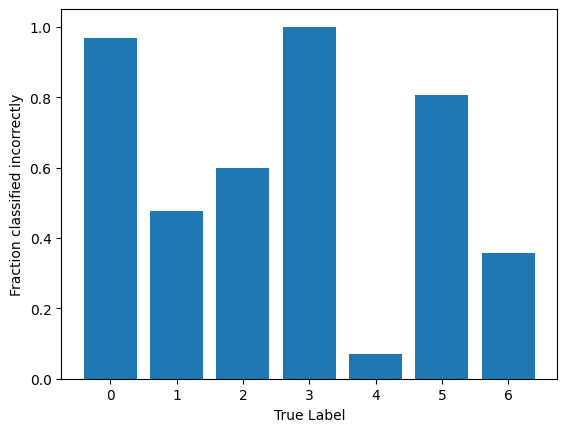

In [139]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

## testing the saved model

In [152]:
# Load the model
model = load_model('model.keras')

# Now you can use the model to evaluate or make predictions
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

/opt/anaconda3/envs/tf_macos/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7640 - loss: 0.6570
Test: accuracy = 0.750874  ;  loss = 0.684211


# conclusion
It seems our model has maximum number of incorrect predictions for Basal cell carcinoma which has code 3, then second most missclassified type is Vascular lesions code 5 then Melanocytic nevi code  0 where as Actinic keratoses code 4 has least misclassified type.